In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Load data
mu = pd.read_json('../Results/processed/mean_returns.json', typ='series')
cov = pd.read_csv('../Results/processed/cov_matrix.csv', index_col=0)
tickers = pd.read_csv('../Results/processed/tickers.txt', header=None)[0].tolist()

mu_vec = mu.loc[tickers].values
Sigma = cov.loc[tickers, tickers].values + 1e-8 * np.eye(len(tickers))

# Optimization
lam = 10
x = cp.Variable(len(tickers))
objective = cp.Minimize(cp.quad_form(x, Sigma) - lam * (mu_vec @ x))
constraints = [cp.sum(x) == 1, x >= 0, x <= 0.3]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.OSQP)

weights = x.value
portfolio_return = float(mu_vec @ weights)
portfolio_risk = float(np.sqrt(weights @ Sigma @ weights))

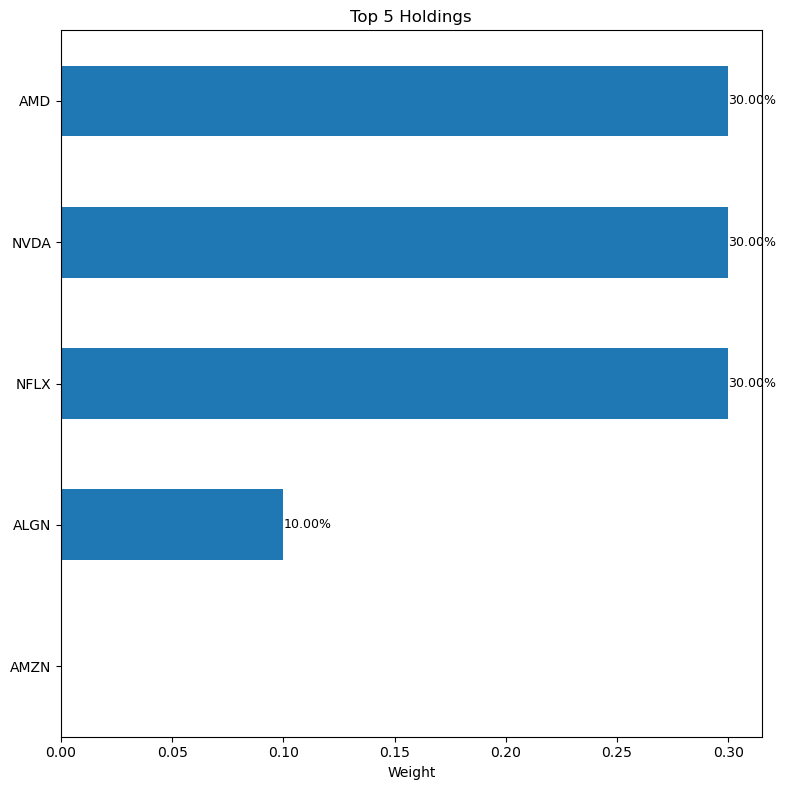

,weight
NFLX,3.000000e-01
NVDA,3.000000e-01
AMD,3.000000e-01
ALGN,1.000000e-01
AMZN,5.920015e-21



Top 5 cover 100.00% of total weight.
Tickers to reach 80% cumulative weight: 3


In [6]:

top_n = 5

import math
# Safety checks
if 'weights' not in globals() or weights is None:
    print('No `weights` found. Run the optimization cell first.')
else:
    w = pd.Series(np.asarray(weights).flatten(), index=tickers).fillna(0)
    # Sort descending to pick top contributors
    w_desc = w.sort_values(ascending=False)
    top = w_desc.head(top_n)
    others_sum = w_desc.iloc[top_n:].sum()

    # Prepare plot series: top N and an 'Others' aggregate if applicable
    plot_series = top.copy()
    if abs(others_sum) > 1e-12:
        plot_series['Others'] = others_sum

    # Horizontal bar plot with decent spacing and font sizes
    n_bars = len(plot_series)
    plt.figure(figsize=(8, 1.2 * n_bars + 2))
    ax = plt.gca()
    # Sort for horizontal display (ascending so largest at top)
    plot_series_plot = plot_series.sort_values(ascending=True)
    colors = ['#1f77b4' if lbl != 'Others' else '#7f7f7f' for lbl in plot_series_plot.index]
    plot_series_plot.plot(kind='barh', color=colors, ax=ax)

    # Annotate values on bars
    for i, (label, val) in enumerate(plot_series_plot.items()):
        if abs(val) > 1e-6:
            ax.text(val + 1e-6, i, f'{val:.2%}', va='center', fontsize=9)

    ax.set_xlabel('Weight')
    ax.set_title(f'Top {top_n} Holdings')
    # Improve y-axis label readability
    ax.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.show()

    # Display the top contributors (nicer table in notebook)
    try:
        display(plot_series.to_frame('weight'))
    except NameError:
        print(plot_series.to_string(formatter=lambda x: f'{x:.4f}'))

    # Print concentration information
    cum = w.sort_values(ascending=False).cumsum()
    pct_top = cum.iloc[top_n-1] if len(cum) >= top_n else cum.iloc[-1] if len(cum)>0 else 0
    print(f"\nTop {top_n} cover {pct_top:.2%} of total weight.")
    # Show how many tickers to reach 80% if useful
    try:
        idx = int(np.searchsorted(cum.values, 0.8))
        n_needed = min(idx + 1, len(cum))
    except Exception:
        n_needed = None
    if n_needed:
        print(f"Tickers to reach 80% cumulative weight: {n_needed}")


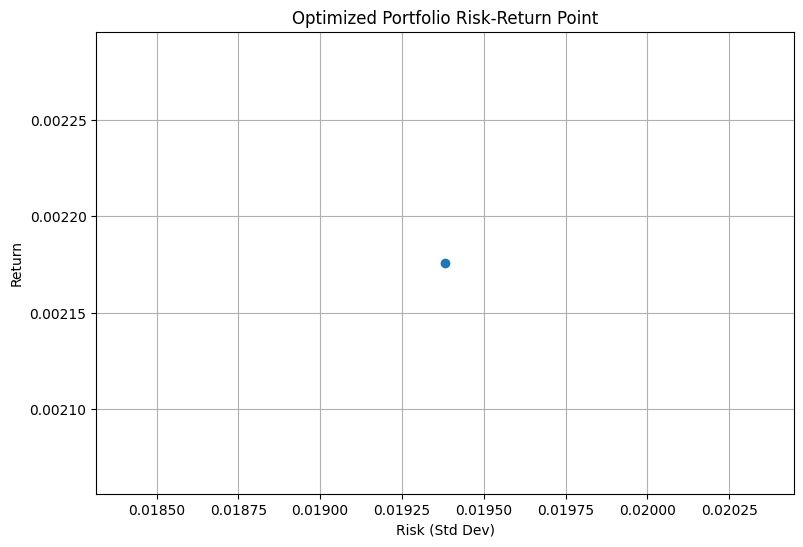

In [ ]:
plt.figure(figsize=(9,6))
plt.scatter([portfolio_risk], [portfolio_return])
plt.xlabel('Risk (Std Dev)')
plt.ylabel('Return')
plt.title('Optimized Portfolio Risk-Return Point')
plt.grid(True)
plt.show()